In [1]:
import os
import numpy as np
import pandas as pd

from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torchvision.transforms import ToTensor
from torch.utils.data import ConcatDataset

from models.unet import Unet
from utils.dataset import HumanDataset
from utils.quality import *

from lib import *
from glob import glob

sns.set(font_scale=1.3)

# Данные

Визуализируем некоторые данные на обучающей выборке

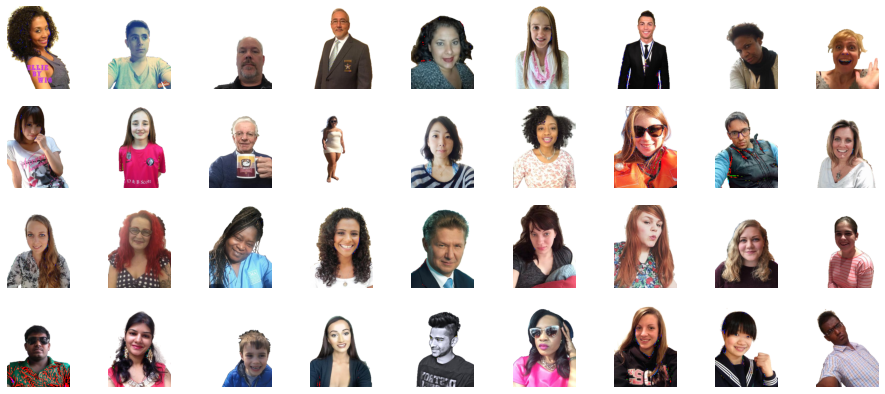

In [2]:
train_image_path = './data/train'
train_mask_path = './data/train_mask'

train_dataset = HumanDataset(train_image_path, train_mask_path)

plt.figure(figsize=(16, 7))
for i in range(205, 205 + 36):
    image, mask = train_dataset[i]
    
    plt.subplot(4, 9, i + 1 - 205)
    cutted_image = image.permute(1, 2, 0).numpy() * mask.numpy().reshape(320, 240, 1)
    cutted_image[cutted_image == 0] = 1
    plt.axis('off')
    plt.imshow(cutted_image)

plt.show()

И на валидационной

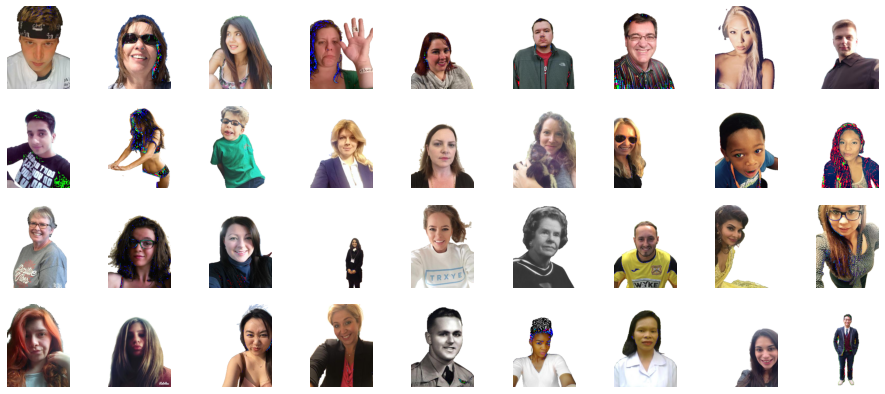

In [3]:
val_image_path = './data/valid'
val_mask_path = './data/valid_mask'

val_dataset = HumanDataset(val_image_path, val_mask_path)

plt.figure(figsize=(16, 7))
for i in range(36):
    image, mask = val_dataset[i]
    
    plt.subplot(4, 9, i + 1)
    cutted_image = image.permute(1, 2, 0).numpy() * mask.numpy().reshape(320, 240, 1)
    cutted_image[cutted_image == 0] = 1
    plt.axis('off')
    plt.imshow(cutted_image)
    
plt.show()

Они представляют из себя фотографии людей, содержащие преимущественно селфи. На части из них присутствуют фильтры, однако большая часть фотографий имеет среднюю яркость, отсутствуют чрезмерно яркие или темные фото. В основном люди запечатлены крупным планом и расположены по центру.  

# Аугментации

В обучающей выборке содержатся 1375 файлов, в валидационной - 145, поэтому искусственно увеличивать обучающий датасет за счет довавлений к нему аугментаций мы не будем. Так как данные содержат много селфи, то имеет смысл применить следующие аугментации:
* Афинное преобразование &mdash; люди нередко фоткаются под углом, поэтому ожидается, что эта аугментация даст существенный прирост к качеству модели
* Изменение яркости, контрастности и насыщенности фотографий &mdash; для увеличения качества распознавания на фотографиях с фильтрами
* Нормализация  
  
Всего 5 аугментаций. Применять горизонтальное отражение мы не будем, так как это имело бы смысл, если бы в нашей выборке было много людей, находящихся справа, в то время как мы ожидаем, что большая часть людей на валидации и тесте будет слева (т.к. подавляющее число людей правши и селфи делают, скорее всего, правой рукой).

# Результаты обучения

Для реализации было выбрано 3 модели &mdash; `Unet` и `DeepLabV3Plus` с 2 различными backbone: `xception` и `resnet101` как модели, показывающие наилучшее качество в задаче сегментаций изображений. Кроме того, архитектура первой уже мне знакома. С обзором архитектур обоих моделей можно ознакомиться в ноутбуке `models_architecture.ipynb`, а с реализациями в папке `models`. 
  
Сначала было обучено 3 модели на данных без аугментации. Ожидалось, что `DeepLabv3Plus` с `xception` покажет наилучшие результаты, однако модель быстро переобучилась (видимо, присутствует ошибка при реализации модели). Наилушее качество на данных получилось у Unet, поэтому для дальнейшего обучения на аугментированных данных было решено выбрать именно эту модель.
  
Выпишем наилучшие значения метрики на валидационной выборке для каждой из моделей:

In [4]:
histories = os.listdir('./history')
histories.remove('unet_finall.csv')
histories.remove('smp_deeplab_pytorch.csv')

labels = ['deeplab+xception (no aug.)', 'deeplab+resnet101 (no aug.)', 'unet (affine aug.)', 'unet (brightness aug.)',
         'unet (contrast aug.)', 'unet (normalization aug.)', 'unet (no aug.)', 'unet (saturation aug.)']

acc = []
for history_path in histories:
    history = pd.read_csv(os.path.join('history', history_path))
    acc.append(history['val_acc'].max())
    
pd.DataFrame(acc, columns=['val dice coeff.'], index=labels)

,val dice coeff.
deeplab+xception (no aug.),0.935916
deeplab+resnet101 (no aug.),0.929178
unet (affine aug.),0.947763
unet (brightness aug.),0.949392
unet (contrast aug.),0.946154
unet (normalization aug.),0.945990
unet (no aug.),0.945928
unet (saturation aug.),0.950103


Наибольший прирост к качеству дали афинное преобразование, изменение яркости и насыщенности изображения, поэтому в финальной модели было решено использовать эти аугментации.  
  
Посмотрим на качество итоговой модели:

In [5]:
unet = Unet().to('cuda')
unet.load_state_dict(torch.load('./saved_models/unet_finall.pth'))
unet.eval()

dice = model_quality(unet, val_dataset)

C:\Users\Константин\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [6]:
print('Dice coefficient для итоговой модели: {}'.format(np.round(dice, 4)))

Dice coefficient для итоговой модели: 0.9569


Качество увеличилось, но не очень сильно.

# Итоговые предсказания

### Маски на валидации

In [7]:
def get_masks(path):
    predicted_masks = []

    image_dir = os.listdir(path)
    for image_name in image_dir:
        image = Image.open(os.path.join(path, image_name))
        prediction = (unet(ToTensor()(image).unsqueeze(0).to('cuda')) > 0) * 1
        predicted_mask = prediction.squeeze(0).squeeze(0).cpu().numpy().astype('int8')

        predicted_masks.append(predicted_mask)
        
    return np.array(predicted_masks)

In [8]:
val_pred_masks = get_masks('./data/valid')
ids = [name.split('.')[0] for name in os.listdir('./data/valid')]

In [9]:
rle_masks = [encode_rle(mask) for mask in val_pred_masks]
pred = pd.DataFrame({'id': ids, 'rle_mask': rle_masks})
pred.head()

,id,rle_mask
0,1315,68 116 308 117 547 120 786 122 1025 124 1264 1...
1,1316,7797 5 8034 1 8037 6 8274 2 8277 7 8513 18 875...
2,1317,8980 7 9215 14 9453 30 9692 40 9931 46 10169 5...
3,1318,4481 5 4487 1 4719 11 4958 13 5000 3 5197 14 5...
4,1319,23609 6 23622 3 23848 19 24071 4 24076 2 24087...


In [10]:
pred.to_csv('./results/pred_valid.csv')

### Предсказания на тесте

In [12]:
test_pred_masks = get_masks('./data/test')

In [14]:
paths_to_imgs = sorted(glob('./data/test/*'))
_ = get_html(paths_to_imgs, test_pred_masks, path_to_save='results/example')